## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, r2_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from torch.utils.data import TensorDataset, DataLoader
import warnings

In [2]:
# ignore warnings
warnings.filterwarnings('ignore')

## Data Loading and Data Preparation

In [4]:
df = pd.read_csv('1df.csv')
df.sample(5)

,age,gender,state,city,studying_yr,department,course_outside_curriculum,cgpa,work_style,family_influence,higher_studies,career_counseling_exp,preferred_career_domains,avg_technical_rating,avg_skill_rating,avg_carrer_choice_rating
46,18,Male,Rajasthan,Tier 2 City,1,Electrical,Yes,6.75,Mixed,No,No,No,Engineering/Manufacturing,1.6,1.6,4.8
0,20,Male,Uttar Pradesh,Metro City,2,Mechanical,No,8.55,Mixed,No,Maybe,No,IT/Tech,2.4,3.3,4.1
40,19,Male,Rajasthan,Tier 2 City,1,Electrical,Yes,7.80,Mixed,No,No,No,Engineering/Manufacturing,1.8,3.0,4.4
131,18,Male,Gujarat,Tier 2 City,1,Electronics,Maybe,6.75,Independent,No,Maybe,No,Engineering/Manufacturing,2.8,2.9,4.1
147,21,Female,Jharkhand,Tier 3 City,2,Mechanical,Yes,7.80,Mixed,No,No,No,Engineering/Manufacturing,1.6,2.3,2.8


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        277 non-null    int64  
 1   gender                     277 non-null    object 
 2   state                      277 non-null    object 
 3   city                       277 non-null    object 
 4   studying_yr                277 non-null    int64  
 5   department                 277 non-null    object 
 6   course_outside_curriculum  277 non-null    object 
 7   cgpa                       277 non-null    float64
 8   work_style                 277 non-null    object 
 9   family_influence           277 non-null    object 
 10  higher_studies             277 non-null    object 
 11  career_counseling_exp      277 non-null    object 
 12  preferred_career_domains   277 non-null    object 
 13  avg_technical_rating       277 non-null    float64

In [6]:
df.describe()

,age,studying_yr,cgpa,avg_technical_rating,avg_skill_rating,avg_carrer_choice_rating
count,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000
mean,19.906137,2.270758,7.751841,2.145848,3.242599,4.111913
std,1.515093,1.015626,1.166432,0.772742,0.840887,0.643222
min,17.000000,1.000000,5.500000,1.000000,1.000000,1.000000
25%,19.000000,1.000000,6.750000,1.500000,2.700000,3.800000
50%,20.000000,2.000000,7.800000,2.000000,3.200000,4.100000
75%,21.000000,3.000000,8.550000,2.600000,3.900000,4.600000
max,30.000000,4.000000,10.000000,4.400000,5.000000,5.000000


In [7]:
# check for missing values
print(df.isnull().sum())

age                          0
gender                       0
state                        0
city                         0
studying_yr                  0
department                   0
course_outside_curriculum    0
cgpa                         0
work_style                   0
family_influence             0
higher_studies               0
career_counseling_exp        0
preferred_career_domains     0
avg_technical_rating         0
avg_skill_rating             0
avg_carrer_choice_rating     0
dtype: int64


### Exploratory Data Analysis

#### Histograms, Boxplots and Countplots

<Figure size 1200x600 with 0 Axes>

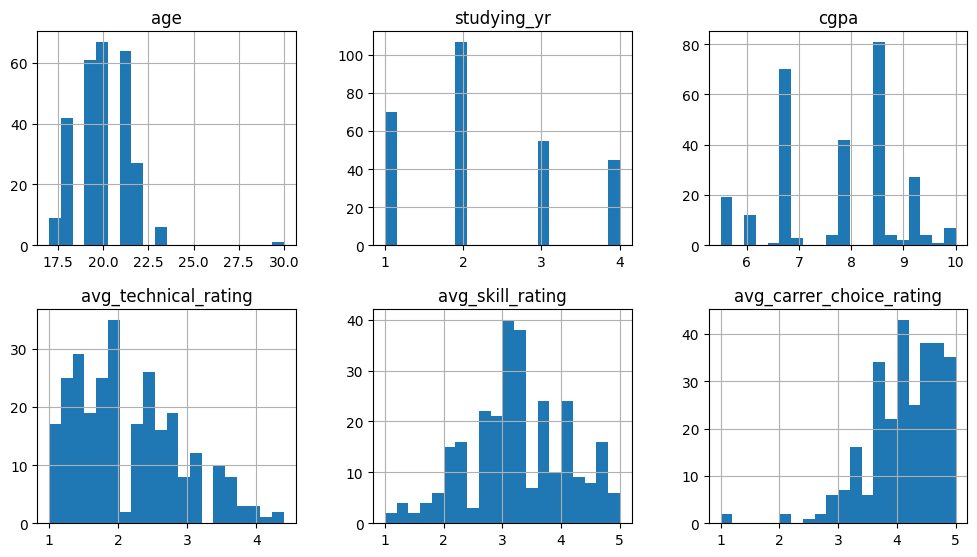

In [8]:
# for numerical cols
plt.figure(figsize=(12, 6))
df.hist(bins=20, figsize=(12, 10), layout=(3, 3))
plt.show()

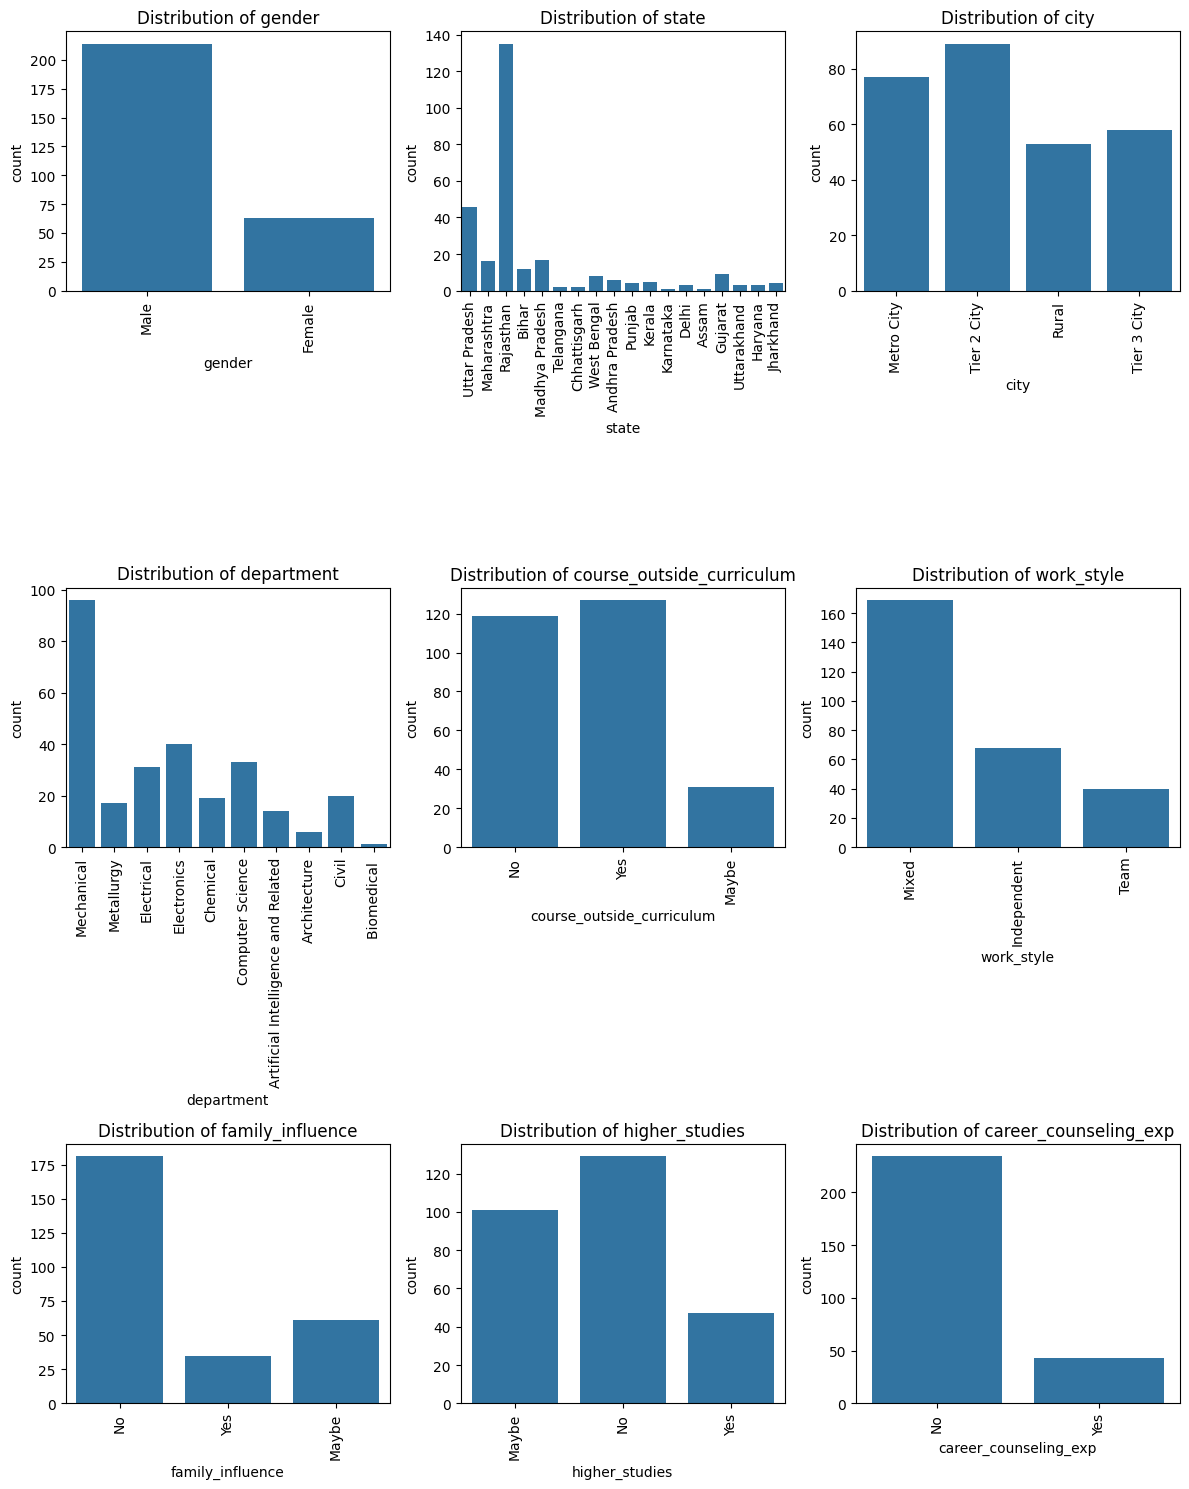

In [9]:
# for categorical columns
categorical_cols = ['gender', 'state', 'city', 'department', 'course_outside_curriculum',
                    'work_style', 'family_influence', 'higher_studies', 'career_counseling_exp']
# for subplots
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12,15))
# flatten for iteration
axes = axes.flatten()

#plot
for i, col in enumerate(categorical_cols):
    sns.countplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

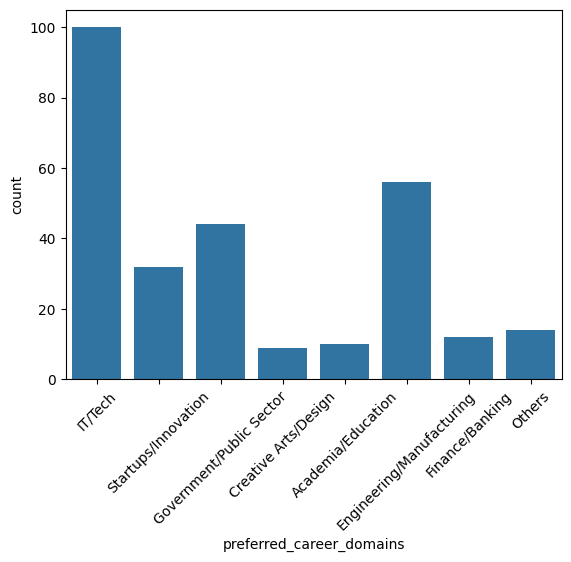

In [10]:
# countplot of target col
sns.countplot(x=df['preferred_career_domains']).tick_params(axis='x', rotation=45)

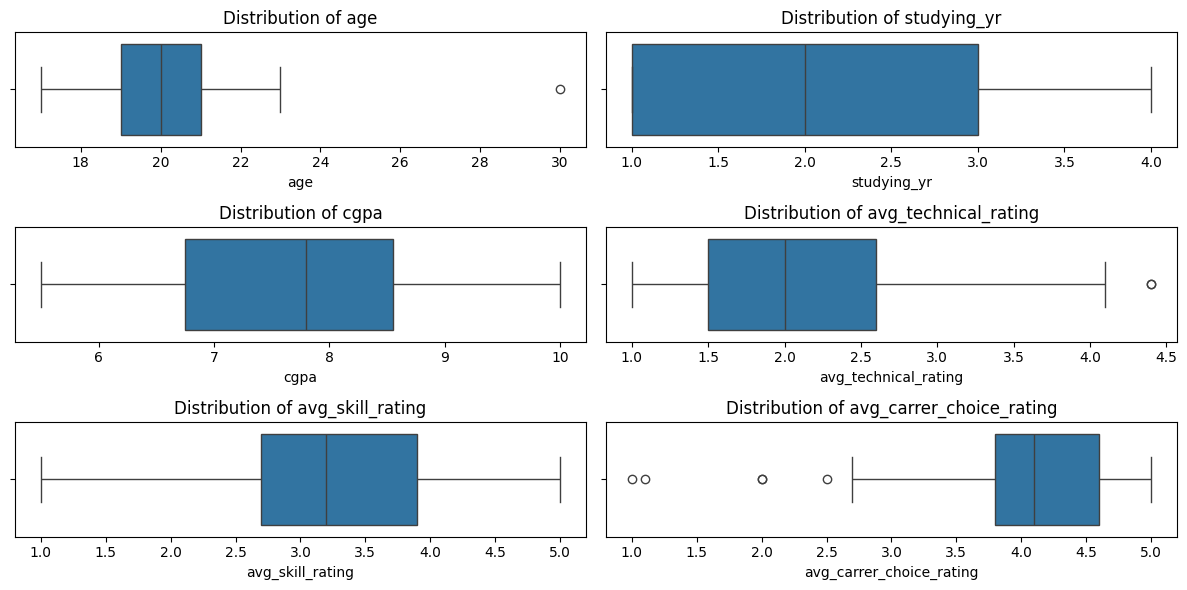

In [11]:
# boxplots for numerical cols
fig, axes = plt.subplots(3,2, figsize=(12,6))
axes = axes.flatten()

numerical_cols = ['age', 'studying_yr', 'cgpa', 'avg_technical_rating',
                      'avg_skill_rating', 'avg_carrer_choice_rating']
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].tick_params(axis='x')
plt.tight_layout()
plt.show()

#### Heatmaps

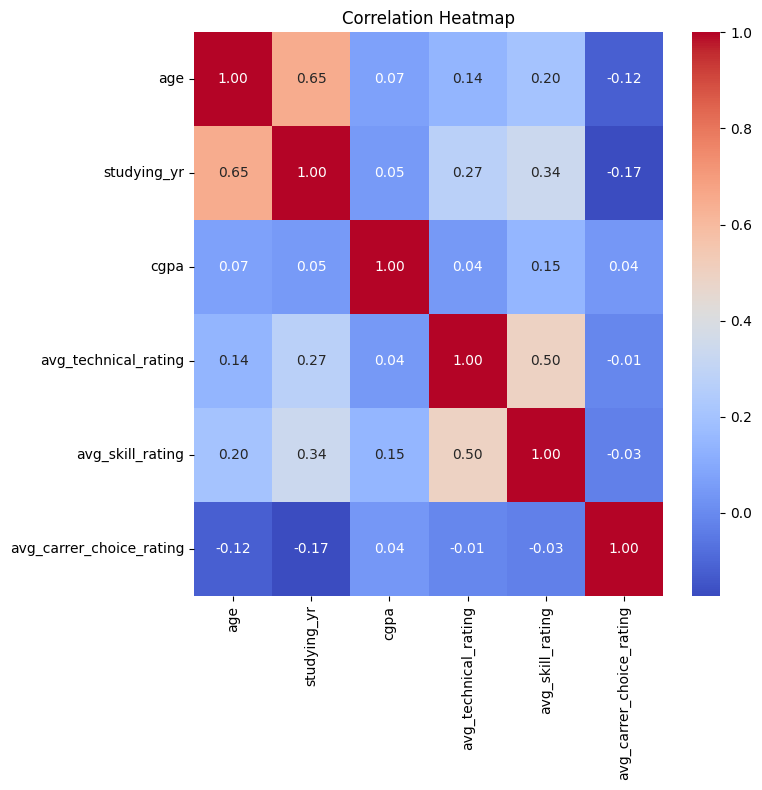

In [13]:
# correlation heatmap
plt.figure(figsize=(8,8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

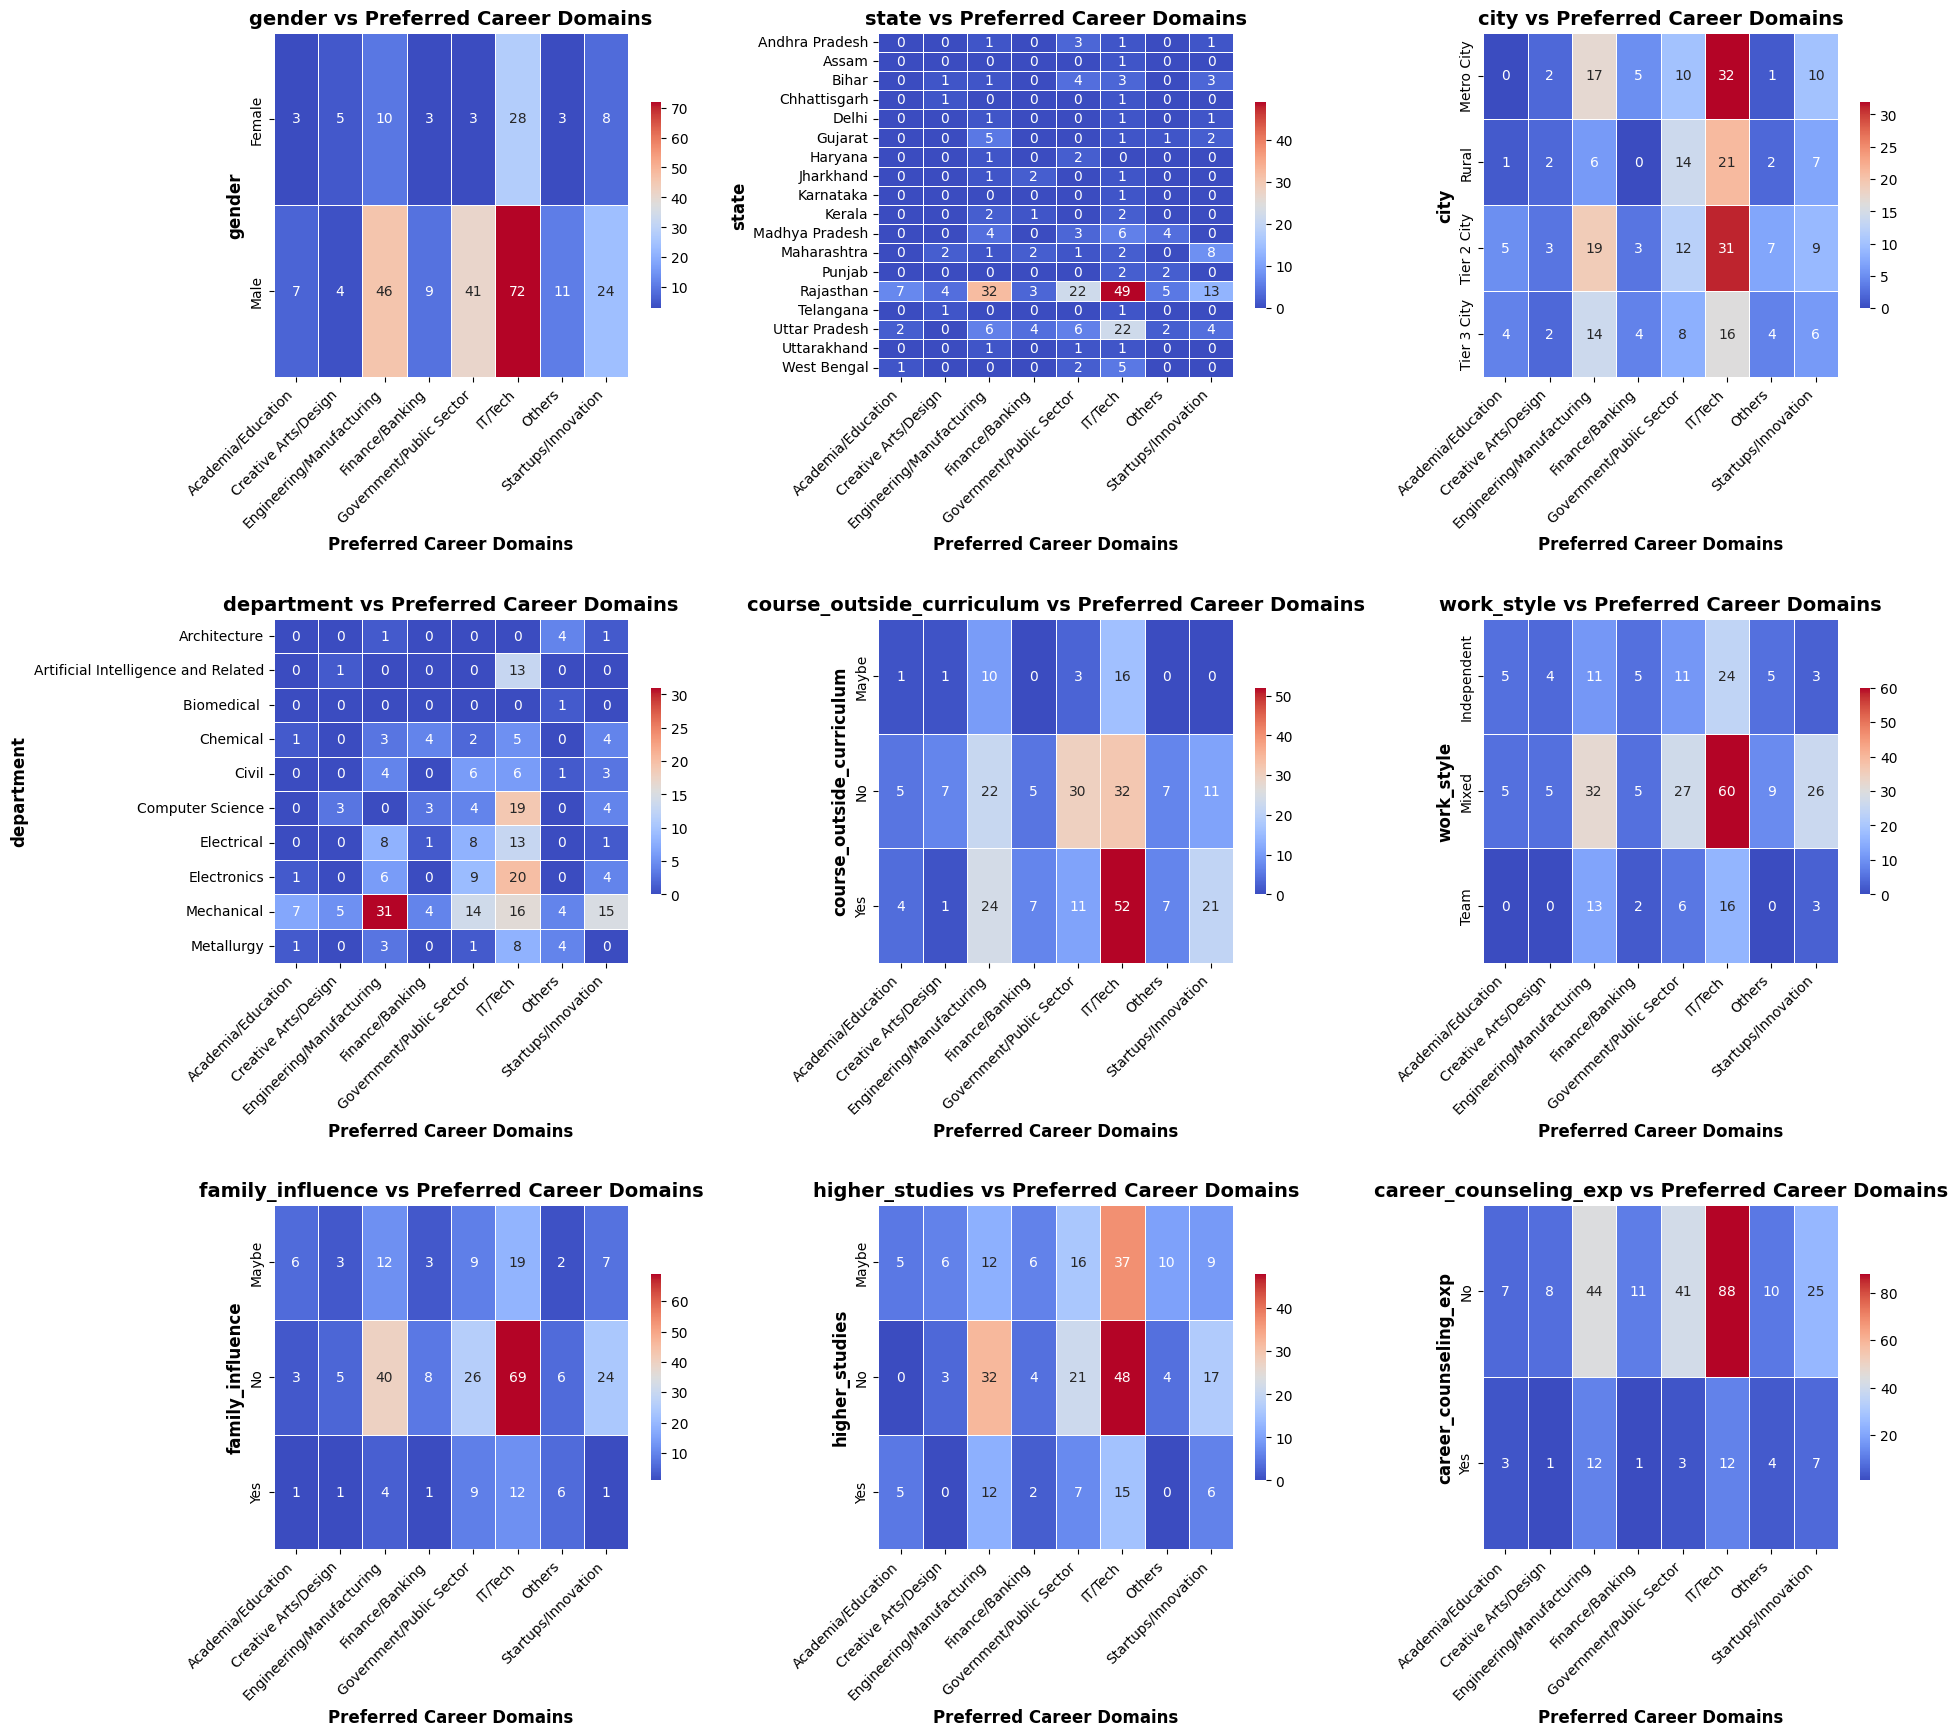

In [14]:
# heatmap b/w catgeorical cols and target cols
plt.figure(figsize=(20,18))

for i, col in enumerate(categorical_cols, 1):
    # subplots
    plt.subplot(3, 3, i)
    
    crosstab = pd.crosstab(df[col], df['preferred_career_domains'])
    
    sns.heatmap(crosstab, annot=True, cmap="coolwarm", fmt="d", linewidths=0.5,
                cbar=True, cbar_kws={'shrink': 0.6}) # arguments to make plot nice

    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel("Preferred Career Domains", fontsize=12, fontweight='bold')
    plt.ylabel(col, fontsize=12, fontweight='bold')
    plt.title(f"{col} vs Preferred Career Domains", fontsize=14, fontweight='bold')
plt.tight_layout(pad=3)
plt.show()

## Data Preprocessing

In [16]:
# Label encoding target variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['preferred_career_domains'] = le.fit_transform(df['preferred_career_domains'])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Original Label -> Encoded Label")
for original, encoded in label_mapping.items():
    print(f"{original} -> {encoded}")
    
# label encoder class assigns numbers after sorting the column's name alphabetically

Original Label -> Encoded Label
Academia/Education -> 0
Creative Arts/Design -> 1
Engineering/Manufacturing -> 2
Finance/Banking -> 3
Government/Public Sector -> 4
IT/Tech -> 5
Others -> 6
Startups/Innovation -> 7


**Categorical Columns**

- One-Hot cols: `gender`, `state`, `department`, `work_style`
- Binary cols: `career_counseling_exp`
- Ordinal cols: `city`
- maybe cols: `course_outside_curriculum`,`higher_studies`,`family_influence`

### Column Transformer

In [17]:
ohe = OneHotEncoder(sparse_output=False, drop="first")
# sparse: False -> returns numpy array
# drop = first -> to avoid dummy variable trap

oe = OrdinalEncoder(categories=[["Rural", "Tier 3 City", "Tier 2 City", "Metro City"],
                               ['No', 'Yes']])
#numeric transform pipeline
numeric_transf = Pipeline(steps =[
    ("num_scaler", StandardScaler()),
    ("pca", PCA(n_components=4))
])
# column transformer
ct = ColumnTransformer([
    ("num", numeric_transf, ['age', 'studying_yr', 'cgpa',
                                      'avg_technical_rating','avg_skill_rating', 
                                      'avg_carrer_choice_rating']),
    ("one_hot", ohe, ["gender", "state", "department",
                      "work_style", "course_outside_curriculum",
                       "higher_studies", "family_influence" ]),
    ("ord_enc", oe, ["city", "career_counseling_exp"]),
], remainder="passthrough")
ct

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('num_scaler',
                                                  StandardScaler()),
                                                 ('pca', PCA(n_components=4))]),
                                 ['age', 'studying_yr', 'cgpa',
                                  'avg_technical_rating', 'avg_skill_rating',
                                  'avg_carrer_choice_rating']),
                                ('one_hot',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['gender', 'state', 'department', 'work_style',
                                  'course_outside_curriculum', 'higher_studies',
                                  'family_influence']),
                                ('ord_enc',
                                 OrdinalEncoder(categories=[['Rural',
                                                             'Tier 3 City',
                                                             'Tier 2 City',
                                                             'Metro City'],
                                                            ['No', 'Yes']]),
                                 ['city', 'career_counseling_exp'])])

### Labels and Targets

In [18]:
X = df.drop(columns = ['preferred_career_domains'])
y = df['preferred_career_domains']

X.shape, y.shape

((277, 15), (277,))

### Train Test Split and apply transforms

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((221, 15), (56, 15), (221,), (56,))

In [52]:
# applying transforms
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [53]:
# convert numpy array to dataframe
pd.DataFrame(X_train, columns=ct.get_feature_names_out()).sample(5)

,num__pca0,num__pca1,num__pca2,num__pca3,one_hot__gender_Male,one_hot__state_Assam,one_hot__state_Bihar,one_hot__state_Chhattisgarh,one_hot__state_Delhi,one_hot__state_Gujarat,...,one_hot__work_style_Mixed,one_hot__work_style_Team,one_hot__course_outside_curriculum_No,one_hot__course_outside_curriculum_Yes,one_hot__higher_studies_No,one_hot__higher_studies_Yes,one_hot__family_influence_No,one_hot__family_influence_Yes,ord_enc__city,ord_enc__career_counseling_exp
0,-0.221988,1.180467,0.649657,-0.770749,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0
95,-1.375977,0.512177,0.062648,0.058754,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0
56,-1.239467,1.505713,1.649990,0.477618,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
69,0.093570,-0.292385,-1.339334,-1.648984,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
29,1.347075,-0.764199,0.320213,0.683487,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0


### Generate Synthetic data using SMOTE

as there are less samples for each of the target label i.e imbalanced daatset, we can try SMOTE to create synthetic data for minority classes

`SMOTE`: synthetic minority oversampling technique
How SMOTE works:
- for each sample in minority class it finds its k nearest neighours.
- then selects one or more of these neighours at random
- for each selected neighour, it creats a new synthrtic example
- `synthetic = X + delta*(Xneighbour - X)`
 
in our case, our data is high dimensional with many categorical columns, so might be good possibility SMOTE doesn't work well

In [24]:
smote = SMOTE(
    # sampling_strategy={0: 20, 1: 20, 3: 20, 6: 20}, # custom SMOTE
    k_neighbors=2, 
    random_state=123)
X_res, y_res = smote.fit_resample(X_train, y_train)
X_res.shape

(656, 41)

## TRAINING DIFFERENT MODELS

### Logistic Regression

In [26]:
lr = LogisticRegression(
    multi_class='multinomial',
    solver= 'lbfgs', # optimization algo, efficient for large dataset. works well in our case
    max_iter=1000, # max iterations for the solver to converge
    random_state=123
)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Confusion Matrix: ', cm)
print('\nClassification Report:\n', cr)
print('\nAccuracy: ', acc)
print('\nR2 Score: ', r2)

Confusion Matrix:  [[ 0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  1]
 [ 0  0  9  0  2  6  0]
 [ 0  0  0  0  0  1  0]
 [ 1  0  2  1  5  1  1]
 [ 1  0  0  1  1 13  2]
 [ 0  0  2  0  0  2  3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         2
           2       0.64      0.53      0.58        17
           3       0.00      0.00      0.00         1
           4       0.62      0.45      0.53        11
           5       0.57      0.72      0.63        18
           7       0.43      0.43      0.43         7

    accuracy                           0.54        56
   macro avg       0.32      0.30      0.31        56
weighted avg       0.55      0.54      0.54        56


Accuracy:  0.5357142857142857

R2 Score:  -0.3934495959166311


#### On SMOTE data

In [27]:
lr.fit(X_res, y_res)
y_pred = lr.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Confusion Matrix: ', cm)
print('\nClassification Report:\n', cr)
print('\nAccuracy: ', acc)
print('\nR2 Score: ', r2)

Confusion Matrix:  [[0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0]
 [3 0 8 1 4 1 0]
 [0 0 0 1 0 0 0]
 [1 1 1 3 4 0 1]
 [1 0 1 1 1 9 5]
 [0 1 1 1 0 1 3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.33      0.50      0.40         2
           2       0.67      0.47      0.55        17
           3       0.14      1.00      0.25         1
           4       0.44      0.36      0.40        11
           5       0.82      0.50      0.62        18
           7       0.33      0.43      0.38         7

    accuracy                           0.46        56
   macro avg       0.39      0.47      0.37        56
weighted avg       0.61      0.46      0.51        56


Accuracy:  0.4642857142857143

R2 Score:  -0.31008081667375564


**Logistic regression** performance is not good

training on extended dataset(smote) *decreased* performance

reason -> imbalanced dataset (decision tree are sensitive to imbalance dataset

Tried for **Decision Tree**, doesn't work well.

### Random Forest
Random forest algo is the ensemble of multiple decision trees, combines their predictions to make final decision --reducing overfiting and improving accuracy

- it's like asking 100 different experts to have there opinion, then go with majority

In [28]:
rf = RandomForestClassifier(
    n_estimators=100, # num of decision trees
    max_depth=10, # max depth of each tree
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced', # to adjust class imbalance
    random_state = 123)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

cm = confusion_matrix(y_test, rf_y_pred)
acc = accuracy_score(y_test, rf_y_pred)
cr = classification_report(y_test, rf_y_pred)
r2 = r2_score(y_test, rf_y_pred)

print('Confusion Matrix: ', cm)
print('\nClassification Report:\n', cr)
print('\nAccuracy: ', acc)
print('\nR2 Score: ', r2)

Confusion Matrix:  [[ 0  0  0  0  0  0  0]
 [ 1  0  0  1  0  0  0]
 [ 0  0 12  0  4  1  0]
 [ 0  0  0  0  0  1  0]
 [ 1  0  0  0  8  2  0]
 [ 1  0  0  0  1 15  1]
 [ 0  0  0  0  0  1  6]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         2
           2       1.00      0.71      0.83        17
           3       0.00      0.00      0.00         1
           4       0.62      0.73      0.67        11
           5       0.75      0.83      0.79        18
           7       0.86      0.86      0.86         7

    accuracy                           0.73        56
   macro avg       0.46      0.45      0.45        56
weighted avg       0.77      0.73      0.74        56


Accuracy:  0.7321428571428571

R2 Score:  0.4878774989366228


### XGBoost
Extreme Gradient Boosting

XGBoost - ensemble of decision trees, but here each one learns from mistakes of the previous one.

It's like:
1. tree 1 makes a pred
2. tree 2 focuses what t1 got wrong and so on
   
What's Special
1. uses gradient descent to minimize loss func (like in nn)
2. regularization (avoids overfitting)

In [29]:
xgb = XGBClassifier(
    max_depth= 4,
    colsample_by_tree =0.8, # percentage of features used per tree
    random_state = 123,
    learning_rate=0.1,
    n_estimators=300)
xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_test)

cm = confusion_matrix(y_test, xgb_y_pred)
acc = accuracy_score(y_test, xgb_y_pred)
cr = classification_report(y_test, xgb_y_pred)
r2 = r2_score(y_test, xgb_y_pred)

print('Confusion Matrix: ', cm)
print('\nClassification Report:\n', cr)
print('\nAccuracy: ', acc)
print('\nR2 Score: ', r2)

Confusion Matrix:  [[ 0  0  0  0  0  0  0]
 [ 0  0  1  0  1  0  0]
 [ 2  0  8  0  3  4  0]
 [ 0  0  0  0  0  1  0]
 [ 1  0  1  0  7  2  0]
 [ 0  1  1  0  0 15  1]
 [ 0  0  1  0  0  1  5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         2
           2       0.67      0.47      0.55        17
           3       0.00      0.00      0.00         1
           4       0.64      0.64      0.64        11
           5       0.65      0.83      0.73        18
           7       0.83      0.71      0.77         7

    accuracy                           0.62        56
   macro avg       0.40      0.38      0.38        56
weighted avg       0.64      0.62      0.62        56


Accuracy:  0.625

R2 Score:  0.10676307954062114


#### applying xgboost after smote

In [31]:
xgb.fit(X_res, y_res)
xgb_y_pred = xgb.predict(X_test)

cm = confusion_matrix(y_test, xgb_y_pred)
acc = accuracy_score(y_test, xgb_y_pred)
cr = classification_report(y_test, xgb_y_pred)
r2 = r2_score(y_test, xgb_y_pred)

print('Confusion Matrix: ', cm)
print('\nClassification Report:\n', cr)
print('\nAccuracy: ', acc)
print('\nR2 Score: ', r2)

Confusion Matrix:  [[ 0  0  0  0  0  0  0]
 [ 0  0  1  1  0  0  0]
 [ 2  0  9  0  0  6  0]
 [ 0  0  0  0  0  1  0]
 [ 0  0  0  1  7  2  1]
 [ 0  0  1  1  0 16  0]
 [ 0  0  1  0  0  1  5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         2
           2       0.75      0.53      0.62        17
           3       0.00      0.00      0.00         1
           4       1.00      0.64      0.78        11
           5       0.62      0.89      0.73        18
           7       0.83      0.71      0.77         7

    accuracy                           0.66        56
   macro avg       0.46      0.40      0.41        56
weighted avg       0.73      0.66      0.67        56


Accuracy:  0.6607142857142857

R2 Score:  0.25563589961718425


### CatBoost Classifier
it handles categorical features natively, no need to encode them.

it transforms them internally using a method called "ordered target statistics"

#### 1. Applying CatBoost on raw data(non-encoded data)

In [32]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y, test_size=0.2, random_state=123)

In [34]:
# X_train_cat.sample()

In [35]:
cat_features = ['gender', 'state', 'city', 'department','course_outside_curriculum','work_style',
                'family_influence','higher_studies','career_counseling_exp']

cgb = CatBoostClassifier(
    cat_features = cat_features,
    iterations=300,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=123,
    verbose=0 #no metadata
)

cgb.fit(X_train_cat, y_train_cat)
cgb_y_pred = cgb.predict(X_test_cat)

cm = confusion_matrix(y_test_cat, cgb_y_pred)
acc = accuracy_score(y_test_cat, cgb_y_pred)
cr = classification_report(y_test_cat, cgb_y_pred)
r2 = r2_score(y_test_cat, cgb_y_pred)

print('Confusion Matrix: ', cm)
print('\nClassification Report:\n', cr)
print('\nAccuracy: ', acc)
print('\nR2 Score: ', r2)

Confusion Matrix:  [[ 0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0]
 [ 1  0  7  0  0  9  0]
 [ 0  0  1  0  0  0  0]
 [ 0  0  1  0  3  7  0]
 [ 0  0  0  0  1 16  1]
 [ 0  0  0  0  0  4  3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         2
           2       0.64      0.41      0.50        17
           3       0.00      0.00      0.00         1
           4       0.75      0.27      0.40        11
           5       0.44      0.89      0.59        18
           7       0.75      0.43      0.55         7

    accuracy                           0.52        56
   macro avg       0.37      0.29      0.29        56
weighted avg       0.58      0.52      0.49        56


Accuracy:  0.5178571428571429

R2 Score:  0.2854104636324969


the above cell take 1-2 min to run.

let's apply catboost on already encoded data, to see whether it performs well on not

#### 2. Applying CatBoost on encoded data

In [36]:
cgb = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=123,
    verbose=0 #no metadata
)

cgb.fit(X_train, y_train)
cgb_y_pred = cgb.predict(X_test)

cm = confusion_matrix(y_test, cgb_y_pred)
acc = accuracy_score(y_test, cgb_y_pred)
cr = classification_report(y_test, cgb_y_pred)
r2 = r2_score(y_test, cgb_y_pred)

print('Confusion Matrix: ', cm)
print('\nClassification Report:\n', cr)
print('\nAccuracy: ', acc)
print('\nR2 Score: ', r2)

Confusion Matrix:  [[ 1  0  1  0  0  0]
 [ 0  9  0  1  7  0]
 [ 0  0  0  0  1  0]
 [ 0  1  0  7  3  0]
 [ 0  1  0  0 16  1]
 [ 0  0  0  0  1  6]]

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.50      0.67         2
           2       0.82      0.53      0.64        17
           3       0.00      0.00      0.00         1
           4       0.88      0.64      0.74        11
           5       0.57      0.89      0.70        18
           7       0.86      0.86      0.86         7

    accuracy                           0.70        56
   macro avg       0.69      0.57      0.60        56
weighted avg       0.75      0.70      0.69        56


Accuracy:  0.6964285714285714

R2 Score:  0.41046363249680995


### MLPClassifier (Multi Layer Perceptron)
It’s a feedforward neural network for classification tasks.
An MLP has:

1. Input layer: accepts features

2. Hidden layers: where learning happens (customizable)

3. Output layer: gives class probabilities

In [37]:
mlp = MLPClassifier(
    hidden_layer_sizes=(64,32), # 2 hidden layers with 64 and 32 neurons
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    max_iter=500,
    # early_stopping=True,
    random_state=123
)
mlp.fit(X_train, y_train)
mlp_y_pred = mlp.predict(X_test)

cm = confusion_matrix(y_test, mlp_y_pred)
acc = accuracy_score(y_test, mlp_y_pred)
cr = classification_report(y_test, mlp_y_pred)
r2 = r2_score(y_test, mlp_y_pred)

print('Confusion Matrix: ', cm)
print('\nClassification Report:\n', cr)
print('\nAccuracy: ', acc)
print('\nR2 Score: ', r2)

Confusion Matrix:  [[ 1  1  0  0  0  0]
 [ 0 12  0  2  3  0]
 [ 0  0  0  1  0  0]
 [ 0  1  1  7  1  1]
 [ 0  1  1  0 14  2]
 [ 0  0  0  0  1  6]]

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.50      0.67         2
           2       0.80      0.71      0.75        17
           3       0.00      0.00      0.00         1
           4       0.70      0.64      0.67        11
           5       0.74      0.78      0.76        18
           7       0.67      0.86      0.75         7

    accuracy                           0.71        56
   macro avg       0.65      0.58      0.60        56
weighted avg       0.74      0.71      0.72        56


Accuracy:  0.7142857142857143

R2 Score:  0.5414717141641855


#### on SMOTE data

In [38]:
mlp.fit(X_res, y_res)
mlp_y_pred = mlp.predict(X_test)

cm = confusion_matrix(y_test, mlp_y_pred)
acc = accuracy_score(y_test, mlp_y_pred)
cr = classification_report(y_test, mlp_y_pred)
r2 = r2_score(y_test, mlp_y_pred)

print('Confusion Matrix: ', cm)
print('\nClassification Report:\n', cr)
print('\nAccuracy: ', acc)
print('\nR2 Score: ', r2)

Confusion Matrix:  [[ 0  0  0  0  0  0  0]
 [ 0  1  1  0  0  0  0]
 [ 3  0  8  0  2  4  0]
 [ 0  0  0  0  1  0  0]
 [ 0  0  0  0  7  3  1]
 [ 0  0  1  2  0 13  2]
 [ 0  0  0  0  1  1  5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.50      0.67         2
           2       0.80      0.47      0.59        17
           3       0.00      0.00      0.00         1
           4       0.64      0.64      0.64        11
           5       0.62      0.72      0.67        18
           7       0.62      0.71      0.67         7

    accuracy                           0.61        56
   macro avg       0.53      0.43      0.46        56
weighted avg       0.68      0.61      0.63        56


Accuracy:  0.6071428571428571

R2 Score:  0.35686941726924715


### KNeighborsClassifier
1. Choose the number of neighbors, K.

2. Calculate the distance (usually Euclidean) from the new point to all training points.

3. Find the K closest neighbors.

4. Assign the class based on a majority vote among those K neighbors.


In [41]:
knn = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    algorithm='auto',
    leaf_size=30,
    p=2  # Euclidean distance
)

knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, knn_y_pred)
acc = accuracy_score(y_test, knn_y_pred)
cr = classification_report(y_test, knn_y_pred)
r2 = r2_score(y_test, knn_y_pred)

print('Confusion Matrix: ', cm)
print('\nClassification Report:\n', cr)
print('\nAccuracy: ', acc)
print('\nR2 Score: ', r2)

Confusion Matrix:  [[ 0  0  0  0  0  0  0  0]
 [ 0  1  0  1  0  0  0  0]
 [ 3  0  9  1  0  4  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  1  0  7  3  0  0]
 [ 0  0  0  0  0 16  0  2]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  6]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.50      0.67         2
           2       0.90      0.53      0.67        17
           3       0.00      0.00      0.00         1
           4       0.88      0.64      0.74        11
           5       0.70      0.89      0.78        18
           6       0.00      0.00      0.00         0
           7       0.75      0.86      0.80         7

    accuracy                           0.70        56
   macro avg       0.53      0.43      0.46        56
weighted avg       0.80      0.70      0.72        56


Accuracy:  0.6964285714285714

R2 Score:  0.5831561037856232


## Extras!!

### Ensemble with random forest, xgboost and knn

In [42]:
rf_clf = RandomForestClassifier(
    n_estimators=100, # num of decision trees
    max_depth=10, # max depth of each tree
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced', # to adjust class imbalance
    random_state = 123)

xgb_clf = XGBClassifier(
    max_depth= 4,
    colsample_by_tree =0.8, # percentage of features used per tree
    random_state = 123,
    learning_rate=0.1,
    n_estimators=300)

knn_clf = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    algorithm='auto',
    leaf_size=30,
    p=2,  # Euclidean distance
)

#ensemble
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_clf),
        ('xgb', xgb_clf),
        ('knn', knn_clf)
    ],
    voting='soft'  # soft voting for probabilistic averaging
)
voting_clf

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=10,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     random_state=123)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_by_tree=0.8,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enab...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None, ...)),
                             ('knn', KNeighborsClassifier(weights='distance'))],
                 voting='soft')

In [46]:
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('\nClassification Report:\n', cr)
print('\nAccuracy: ', acc)
print('\nR2 Score: ', r2)


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         2
           2       0.67      0.47      0.55        17
           3       0.00      0.00      0.00         1
           4       0.70      0.64      0.67        11
           5       0.62      0.83      0.71        18
           7       0.71      0.71      0.71         7

    accuracy                           0.62        56
   macro avg       0.39      0.38      0.38        56
weighted avg       0.63      0.62      0.62        56


Accuracy:  0.625

R2 Score:  0.29732028923862197


In [48]:
# on smote data
voting_clf.fit(X_res, y_res)
y_pred = voting_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('\nClassification Report:\n', cr)
print('\nAccuracy: ', acc)
print('\nR2 Score: ', r2)


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.50      0.67         2
           2       0.91      0.59      0.71        17
           3       0.00      0.00      0.00         1
           4       0.78      0.64      0.70        11
           5       0.75      0.83      0.79        18
           6       0.00      0.00      0.00         0
           7       0.75      0.86      0.80         7

    accuracy                           0.70        56
   macro avg       0.52      0.43      0.46        56
weighted avg       0.80      0.70      0.73        56


Accuracy:  0.6964285714285714

R2 Score:  0.4819225861335602


### A simple NN using Pytorch

1. convert tabular data to Dataset (using TensorDataset)
2. Load and prepare train and test using DataLoader
3. Define model class
4. Set learning rate, loss function, optimizer
5. Define training loop
6. Get train test loss and accuracy

In [54]:
torch.manual_seed(123)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
X_train = X_train.astype(float)
X_test = X_test.astype(float)

In [55]:
# to tensor
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train)

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test)

In [56]:
# check datatype
X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype

(torch.float32, torch.int64, torch.float32, torch.int64)

In [59]:
# Train Dataset and Dataloader
# dataset
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

# dataloader
batch_size = 4
train_loader = DataLoader(dataset= train_ds, batch_size = batch_size, shuffle= True)
test_loader = DataLoader(dataset= test_ds, batch_size = batch_size)

**NN model**

`input_size` = 41 (num of features)

`n_hidden_layers` = 2

`hidden_size` = 64

`output_size` = 8 (classes in target column) 

In [60]:
class NNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        return x

In [62]:
input_size = X_train.shape[-1]
hidden_size = 64
output_size = 8

# create model instance
model = NNModel(input_size, hidden_size, output_size)
model

NNModel(
  (layer1): Linear(in_features=41, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=41, bias=True)
)

In [63]:
# learning rate, optimizer, loss fn
lr = 0.05
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= lr)

In [64]:
# training loop
n_epochs = 50
for epoch in range(n_epochs):
    print(f'Epoch {epoch} -->\n')

    # training
    train_loss = 0
    train_acc = 0
    for X_batch, y_batch in train_loader:
        model.train()
        #forward pass
        y_pred = model(X_batch)
        # loss per batch
        loss = loss_fn(y_pred, y_batch)
        # loss
        train_loss +=loss
        #accuracy
        correct = (torch.argmax(y_pred, dim=1) == y_batch).float()
        train_acc += correct.mean()
        
        #optimizer zero grad
        optimizer.zero_grad()
        #loss backward (backprop)
        loss.backward()
        # optimizer step (grad descent)
        optimizer.step()
    # average loss per batch
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    # testing
    model.eval() # put model to evaluation mode
    test_loss, test_acc = 0,0
    with torch.inference_mode():
        for X, y in test_loader:
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            correct = (torch.argmax(test_pred, dim=1) == y).float()
            test_acc += correct.mean()
        test_loss /= len(test_loader)
        test_acc /= len(test_loader)

    print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {train_acc:.3f}')
    print(f'Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc:.3f}')

Epoch 0 -->

Train Loss: 2.185 | Train Accuracy: 0.290
Test Loss: 1.684 | Test Accuracy: 0.339
Epoch 1 -->

Train Loss: 1.790 | Train Accuracy: 0.384
Test Loss: 1.482 | Test Accuracy: 0.411
Epoch 2 -->

Train Loss: 1.467 | Train Accuracy: 0.429
Test Loss: 1.513 | Test Accuracy: 0.446
Epoch 3 -->

Train Loss: 1.285 | Train Accuracy: 0.518
Test Loss: 1.389 | Test Accuracy: 0.500
Epoch 4 -->

Train Loss: 1.053 | Train Accuracy: 0.589
Test Loss: 1.559 | Test Accuracy: 0.482
Epoch 5 -->

Train Loss: 0.826 | Train Accuracy: 0.701
Test Loss: 1.376 | Test Accuracy: 0.625
Epoch 6 -->

Train Loss: 0.568 | Train Accuracy: 0.835
Test Loss: 1.337 | Test Accuracy: 0.536
Epoch 7 -->

Train Loss: 0.391 | Train Accuracy: 0.875
Test Loss: 1.462 | Test Accuracy: 0.625
Epoch 8 -->

Train Loss: 0.254 | Train Accuracy: 0.938
Test Loss: 1.794 | Test Accuracy: 0.607
Epoch 9 -->

Train Loss: 0.181 | Train Accuracy: 0.951
Test Loss: 1.577 | Test Accuracy: 0.661
Epoch 10 -->

Train Loss: 0.152 | Train Accuracy: 

## INFERENCE

In [65]:
# get columns name
df1 = df.drop(columns = ['preferred_career_domains'])
cols = df1.columns
cols

Index(['age', 'gender', 'state', 'city', 'studying_yr', 'department',
       'course_outside_curriculum', 'cgpa', 'work_style', 'family_influence',
       'higher_studies', 'career_counseling_exp', 'avg_technical_rating',
       'avg_skill_rating', 'avg_carrer_choice_rating'],
      dtype='object')

In [66]:
# input data
# change different values to check how different models are performing
arr = np.array([[20, 'Female', 'Uttar Pradesh', 'Tier 2 City', 2, 'Civil', 
                 'Yes', 6.5, 'Independent', 'Yes',
                 'No','No',2.0,2,3]])
test_df = pd.DataFrame(arr, columns = cols)
test_df

,age,gender,state,city,studying_yr,department,course_outside_curriculum,cgpa,work_style,family_influence,higher_studies,career_counseling_exp,avg_technical_rating,avg_skill_rating,avg_carrer_choice_rating
0,20,Female,Uttar Pradesh,Tier 2 City,2,Civil,Yes,6.5,Independent,Yes,No,No,2.0,2,3


In [67]:
# apply column transform
test_X = ct.transform(test_df)
test_X

array([[-0.75266447, -1.82957597,  0.47839349, -1.50792453,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  2.        ,
         0.        ]])

#### Testing the best performing Models

In [68]:
# RANDOM FOREST
y = rf.predict(test_X)
print(f'Predicted: {y}')

Predicted: [5]


In [69]:
# XGBOOST
y = xgb.predict(test_X)
print(f'Predicted: {y}')

Predicted: [5]


In [70]:
# CATBOOST
y = cgb.predict(test_X)
print(f'Predicted: {y}')

Predicted: [[5]]


In [71]:
# MLP
y = mlp.predict(test_X)
print(f'Predicted: {y}')

Predicted: [5]


In [72]:
# KNN
y = knn.predict(test_X)
print(f'Predicted: {y}')

Predicted: [2]


In [73]:
# NN
# convert it to tensor
X = torch.from_numpy(test_X).float()
model.eval()
logits = model(X) # logits
y = torch.argmax(logits, dim=1)
print(f'Predicted: {y}')

Predicted: tensor([5])


**Targets**

Academia/Education -> 0

Creative Arts/Design -> 1

Engineering/Manufacturing -> 2

Finance/Banking -> 3

Government/Public Sector -> 4

IT/Tech -> 5

Others -> 6

Startups/Innovation -> 7